In [132]:
from ocpa.algo.predictive_monitoring import factory as predictive_monitoring
from ocpa.algo.predictive_monitoring import tabular, sequential
import networkx as nx
import pandas as pd
from karateclub.graph_embedding import graph2vec
from karateclub import DeepWalk, Walklets
import node2vec 
from collections import Counter

In [133]:
from ocpa.objects.log.importer.ocel import factory as ocel_import_factory

def load_ocel(path):
    if path.endswith("jsonocel"):
        ocel_file = ocel_import_factory.apply(path)
    elif path.endswith("xmlocel"):
        ocel_file = ocel_import_factory.apply(path)
    else:
        error_msg = "not a valid extension"
        return error_msg
    return ocel_file

In [134]:
def get_process_executions(ocel):
    # default: connected components
    return ocel.process_executions

def get_events_process_exection(ocel, id):
    return ocel.process_executions[id]

def get_objects_process_execution(ocel, id):
    return ocel.process_execution_objects[id]

def get_process_execution_graph(ocel, id):
    return ocel.get_process_execution_graph(id)

def get_variant_process_executions(ocel):
    return ocel.variants_dict()

In [135]:
def remap_nodes(graph):
    node_mapping = dict((node.event_id, i) for i, node in enumerate(graph.nodes))
    return node_mapping

def feature_graphs_to_nx_graphs(feature_graphs):
    graph_list = []
    for feature_graph in feature_graphs:
        #G = nx.DiGraph()
        G = nx.Graph()

        node_dict = remap_nodes(feature_graph)

        # replace node attribute dict keys (tuples) with only first part of tuple
        for node in feature_graph.nodes:
            new_keys = [key[0] for key in node.attributes.keys()]
            # graph2vec needs str features
            new_vals = [str(val) for val in node.attributes.values()]
            #node_attributes = dict(zip(new_keys, node.attributes.values()))
            node_attributes = dict(zip(new_keys, new_vals))
            G.add_node(node_dict[node.event_id], **node_attributes)
            #G.add_node(node.event_id, **node_attributes)

        for edge in feature_graph.edges:
            G.add_edge(node_dict[edge.source], node_dict[edge.target])
            #G.add_edge(edge.source, edge.target)

        graph_list.append(G)

    return graph_list

In [136]:
def extract_features(ocel_log, feature_set_event, feature_set_obj, repr):
    extraction = []
    feature_storage = predictive_monitoring.apply(ocel_log, feature_set_event, feature_set_obj)
    extraction.append(feature_storage)
    if repr == 'table':
        table = tabular.construct_table(feature_storage)
        extraction.append(table)
    elif repr == 'sequential':
        sequences = sequential.construct_sequence(feature_storage)
        extraction.append(sequences)
    return extraction

In [137]:
def construct_object_df(ocel_log):
    object_types = ocel_log.object_types
    df = pd.DataFrame(columns=[type for type in object_types])
    proc_ex = get_process_executions(ocel_log)
    num_pr_ex = len(proc_ex)
    for i in range(0, num_pr_ex):
        execution = proc_ex[i]
        obj = get_objects_process_execution(ocel_log, i)
        obj_count = Counter(elem[0] for elem in obj)
        obj_dict = pd.DataFrame([obj_count])
        df = pd.concat([df, obj_dict], ignore_index=True)
    return df

**Test Feature Extraction**

In [138]:
path = "C:\\Users\\linab\\Documents\\RWTH Aachen\\Studium\\Semester 3\\Process Discovery\\Samples\\p2p-normal.jsonocel"
ocel_log = load_ocel(path)

In [139]:
# Feature extraction
activities = list(set(ocel_log.log.log["event_activity"].tolist()))
feature_set = [(predictive_monitoring.EVENT_REMAINING_TIME, ()),
               (predictive_monitoring.EVENT_ELAPSED_TIME, ()),
               (predictive_monitoring.EVENT_FLOW_TIME, ())]


In [140]:
feature_storage = extract_features(ocel_log, feature_set, [], "")[0]

In [141]:
# get first graph
feature_graph = feature_storage.feature_graphs[0]

In [142]:
for key in feature_graph.nodes[0].attributes.keys():
    print(key[0])

event_remaining_time
event_elapsed_time
event_flow_time


In [143]:
# print nodes
for node in feature_graph.nodes:
    print(node.event_id)
    print(node.attributes)
    print(node.objects)

4
{('event_remaining_time', ()): 86400.0, ('event_elapsed_time', ()): 864000.0, ('event_flow_time', ()): 259200.0}
[('MATERIAL', 'MATERIAL3'), ('MATERIAL', 'MATERIAL5'), ('MATERIAL', 'MATERIAL2'), ('MATERIAL', 'MATERIAL1'), ('MATERIAL', 'MATERIAL4'), ('MATERIAL', 'MATERIAL0')]
5
{('event_remaining_time', ()): 86400.0, ('event_elapsed_time', ()): 864000.0, ('event_flow_time', ()): 0.0}
[('MATERIAL', 'MATERIAL3'), ('MATERIAL', 'MATERIAL5'), ('MATERIAL', 'MATERIAL2'), ('MATERIAL', 'MATERIAL1'), ('MATERIAL', 'MATERIAL4'), ('MATERIAL', 'MATERIAL0')]
0
{('event_remaining_time', ()): 950400.0, ('event_elapsed_time', ()): 0.0, ('event_flow_time', ()): 0.0}
[('PURCHREQ', 'PURCHREQ0'), ('MATERIAL', 'MATERIAL3'), ('MATERIAL', 'MATERIAL5'), ('MATERIAL', 'MATERIAL2'), ('MATERIAL', 'MATERIAL1'), ('MATERIAL', 'MATERIAL4'), ('MATERIAL', 'MATERIAL0')]
2
{('event_remaining_time', ()): 604800.0, ('event_elapsed_time', ()): 345600.0, ('event_flow_time', ()): 86400.0}
[('PURCHORD', 'PURCHORD0'), ('MATERIAL

In [144]:
# print edges source/ target
for edge in feature_graph.edges:
    print(edge.source, edge.target)
    print(edge.attributes)
    print(edge.objects)

4 5
{}
{('MATERIAL', 'MATERIAL1'), ('MATERIAL', 'MATERIAL2'), ('MATERIAL', 'MATERIAL4'), ('MATERIAL', 'MATERIAL5'), ('MATERIAL', 'MATERIAL0'), ('MATERIAL', 'MATERIAL3')}
5 7
{}
{('MATERIAL', 'MATERIAL1'), ('MATERIAL', 'MATERIAL2'), ('MATERIAL', 'MATERIAL4'), ('MATERIAL', 'MATERIAL5'), ('MATERIAL', 'MATERIAL0'), ('MATERIAL', 'MATERIAL3')}
0 1
{}
{('PURCHREQ', 'PURCHREQ0'), ('MATERIAL', 'MATERIAL1'), ('MATERIAL', 'MATERIAL2'), ('MATERIAL', 'MATERIAL4'), ('MATERIAL', 'MATERIAL5'), ('MATERIAL', 'MATERIAL0'), ('MATERIAL', 'MATERIAL3')}
2 3
{}
{('GDSRCPT', 'GDSRCPT0'), ('MATERIAL', 'MATERIAL1'), ('MATERIAL', 'MATERIAL2'), ('PURCHORD', 'PURCHORD0'), ('MATERIAL', 'MATERIAL4'), ('MATERIAL', 'MATERIAL5'), ('MATERIAL', 'MATERIAL0'), ('MATERIAL', 'MATERIAL3')}
1 2
{}
{('MATERIAL', 'MATERIAL1'), ('MATERIAL', 'MATERIAL2'), ('PURCHORD', 'PURCHORD0'), ('MATERIAL', 'MATERIAL4'), ('MATERIAL', 'MATERIAL5'), ('MATERIAL', 'MATERIAL0'), ('MATERIAL', 'MATERIAL3')}
6 8
{}
{('INVOICE', 'INVOICE1'), ('PURCHORD'

In [145]:
# get nx graph
feature_nx_graph = feature_graphs_to_nx_graphs([feature_graph])[0]

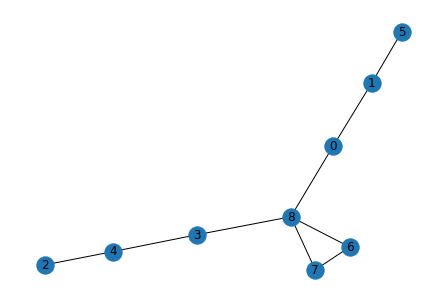

In [146]:
# draw graph
nx.draw(feature_nx_graph, with_labels=True)

In [147]:
from karateclub.graph_embedding import graph2vec

def perform_graph2vec(graph_list, attributed):
    model = graph2vec.Graph2Vec(attributed=attributed)
    model.fit(graph_list)
    X = model.get_embedding()

    return X

In [148]:
X = perform_graph2vec([feature_nx_graph], False)

In [149]:
X

array([[ 6.2402021e-03,  7.3148422e-03,  6.2357578e-03, -5.9866384e-03,
        -6.6280328e-03, -3.5368092e-03, -3.3451244e-03,  3.5964679e-03,
        -5.2057132e-03, -6.6046119e-03, -3.6113895e-03,  7.5855386e-03,
        -3.6392156e-03,  1.1712033e-03,  6.8686884e-03,  3.3843350e-03,
        -7.5897761e-04,  7.2889421e-03, -4.6458151e-03,  4.3180529e-03,
         3.1502247e-03, -2.7489886e-03, -7.2894990e-04, -6.8793725e-03,
         4.1179359e-05, -2.0731930e-03,  7.7435616e-03, -3.6870521e-03,
        -5.2786153e-03,  8.7743253e-04, -6.1075706e-03, -6.2231515e-03,
        -5.1218141e-03, -4.7628861e-03, -3.3969637e-03, -1.5340224e-03,
        -1.9398406e-03,  4.5053940e-03,  5.3389613e-03, -3.5429746e-03,
        -4.9557034e-03,  6.0952269e-04, -3.5226997e-03,  2.0183623e-05,
         5.6065749e-03,  3.0346606e-03, -4.2269900e-03, -1.0023266e-03,
         1.4292635e-04, -6.3144658e-03,  7.7044722e-03,  6.4965114e-03,
        -2.3301691e-05,  4.5703147e-03,  3.5206694e-03,  6.76634

**Extension for all process executions**

In [150]:
feature_graph_list = feature_storage.feature_graphs
feature_nx_graph_list = feature_graphs_to_nx_graphs(feature_graph_list)

In [151]:
print(feature_nx_graph_list[10])

Graph with 9 nodes and 9 edges


In [152]:
print(feature_nx_graph_list[10].nodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [153]:
embedding =perform_graph2vec(feature_nx_graph_list, False)

In [154]:
embedding

array([[ 0.00632935,  0.00735482,  0.00604519, ...,  0.00501382,
         0.00303005,  0.00489794],
       [ 0.00193807,  0.00768754, -0.00262609, ..., -0.00381194,
         0.00399712, -0.00112242],
       [ 0.00597892, -0.0009575 , -0.00692571, ..., -0.00466526,
        -0.00747938,  0.00697827],
       ...,
       [ 0.00645399,  0.00456449,  0.00608036, ...,  0.00451704,
        -0.00467776, -0.00462325],
       [ 0.00443568,  0.00502195, -0.00097741, ...,  0.00190115,
        -0.00249174, -0.00359886],
       [ 0.00670268,  0.0062853 , -0.00172491, ..., -0.00702565,
        -0.00123578, -0.00429699]], dtype=float32)

In [155]:
# try normalize embedding
from sklearn import preprocessing
embedding_normalized = preprocessing.normalize(embedding)
print(embedding_normalized)

[[ 0.12345151  0.14345282  0.11790906 ...  0.09779249  0.05909994
   0.09553235]
 [ 0.03811316  0.15117916 -0.05164344 ... -0.07496364  0.0786054
  -0.02207286]
 [ 0.11239752 -0.01800005 -0.13019612 ... -0.08770215 -0.14060454
   0.13118435]
 ...
 [ 0.12673442  0.089631    0.11939767 ...  0.08869936 -0.09185521
  -0.09078486]
 [ 0.08916494  0.10094992 -0.01964774 ...  0.03821652 -0.05008829
  -0.07234344]
 [ 0.13319679  0.12490252 -0.03427777 ... -0.13961491 -0.02455765
  -0.08539052]]


**Clustering**

In [156]:
from sklearn.cluster import DBSCAN 

def perform_DBSCAN(X):
    labels = DBSCAN(eps=0.1, min_samples=2).fit_predict(X)

    return labels

In [157]:
labels = perform_DBSCAN(embedding)
print(labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]


In [158]:
labels_norm = perform_DBSCAN(embedding_normalized)
print(labels_norm)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1]


In [159]:
from sklearn.cluster import MeanShift

def perform_MeanShift(X):
    clustering = MeanShift().fit(X)

    return clustering.labels_

In [160]:
perform_MeanShift(embedding)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [161]:
perform_MeanShift(embedding_normalized)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

**Try adding a feature**

In [162]:
def feature_graphs_to_nx_graphs_single_feature(feature_graphs):
    graph_list = []
    for feature_graph in feature_graphs:
        #G = nx.DiGraph()
        G = nx.Graph()

        node_dict = remap_nodes(feature_graph)

        # replace node attribute dict keys (tuples) with only first part of tuple
        for node in feature_graph.nodes:
            # graph2vec needs str features
            new_val = [str(val) for val in node.attributes.values()][0]
            G.add_node(node_dict[node.event_id], feature=new_val)
            #G.add_node(node.event_id, **node_attributes)

        for edge in feature_graph.edges:
            G.add_edge(node_dict[edge.source], node_dict[edge.target])
            #G.add_edge(edge.source, edge.target)

        graph_list.append(G)

    return graph_list

In [163]:
# Feature extraction
feature_set_single = [(predictive_monitoring.EVENT_REMAINING_TIME, ())]
feature_storage_single = extract_features(ocel_log, feature_set_single, [], "")[0]

In [164]:
feature_graph_list_single = feature_storage_single.feature_graphs
feature_nx_graph_list_single = feature_graphs_to_nx_graphs_single_feature(feature_graph_list_single)

In [165]:
nx.get_node_attributes(feature_nx_graph_list_single[0], 'feature')

{0: '86400.0',
 1: '86400.0',
 2: '950400.0',
 3: '604800.0',
 4: '691200.0',
 5: '0.0',
 6: '86400.0',
 7: '0.0',
 8: '345600.0'}

In [166]:
embedding_single = perform_graph2vec(feature_nx_graph_list_single, True)

In [167]:
labels_single = perform_DBSCAN(embedding_single)
print(labels_single)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]


In [131]:
perform_MeanShift(embedding_single)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)